# Index of Cell Identity (ICI)

#### Working directory must contain subdirectories,supp_data and src

#### Working directory should contain root atlas Seurat object, which is available on GEO under record GSE152766:

    Root_Atlas.rds (or get it by running through notebook 2)

#### supp_data/ should contain the files, which are available on Github (github.com/Hsu-Che-Wei/COPILOT):

    marker_metadata.csv  
    ici_metadata.csv
    Protoplasting_DEgene_FC2_list.txt (from Denyer, et al. 2019)
    ATH1-121501.na36.annot.csv.bz2 (From Affymetrix)
    included_cell_types.csv

#### supp_data/ should also contain the directory:

    published_datasets/

#### supp_data/published_datasets/ should contain counts data from the RNASeq datasets:

    published_datasets/RNASeq_counts.csv

#### src_ICI/ must contain the file:

    ICI_functions.R

In [1]:
rm(list=ls())
# Set the working directory to where folders named after the samples are located. 
# The folder contains spliced.mtx, unspliced.mtx, barcodes and gene id files, and json files produced by scKB that documents the sequencing stats. 
setwd("/scratch/AG_Ohler/CheWei/scKB")

In [2]:
# Load libraries
.libPaths("/fast/AG_Ohler/CheWei/ICI/packrat/lib/x86_64-conda_cos6-linux-gnu/3.6.2/")
suppressMessages(library(dplyr))
suppressMessages(library(Seurat))
suppressMessages(library(ggplot2))
suppressMessages(library(ICITools))
suppressMessages(library(GEOquery))
suppressMessages(library(affy))
suppressMessages(library(gcrma))
suppressMessages(library(ath1121501cdf))
suppressMessages(library(ath1121501probe))
suppressMessages(library(AnnotationDbi))
suppressMessages(library(IRanges))
suppressMessages(library(S4Vectors))
suppressMessages(library(httr))

options(future.globals.maxSize = 3*(1024^3))
source("./src/ICI_functions.R")

Warning message:
“replacing previous import ‘AnnotationDbi::tail’ by ‘utils::tail’ when loading ‘ath1121501cdf’”
Warning message:
“replacing previous import ‘AnnotationDbi::head’ by ‘utils::head’ when loading ‘ath1121501cdf’”


In [3]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /fast/home/c/chsu/anaconda3/envs/ici/lib/libopenblasp-r0.3.8.so

locale:
 [1] LC_CTYPE=en_US.utf-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.utf-8        LC_COLLATE=en_US.utf-8    
 [5] LC_MONETARY=en_US.utf-8    LC_MESSAGES=en_US.utf-8   
 [7] LC_PAPER=en_US.utf-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.utf-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] httr_1.4.1             ath1121501probe_2.18.0 AnnotationDbi_1.48.0  
 [4] IRanges_2.20.2         S4Vectors_0.24.4       ath1121501cdf_2.18.0  
 [7] gcrma_2.58.0           affy_1.64.0            GEOquery_2.54.1       
[10] Biobase_2.46.0         BiocGenerics_0.32.0   

## 1. Load data

In [4]:
# Define protoplast loci from Denyer, et al. (2019)
protoplast_loci <- as.character(read.table("./supp_data/Protoplasting_DEgene_FC2_list.txt", header=F)$V1)

In [5]:
# Load in sample metadata from previously published datasets, along with marker metadata associating marker genes with cell types, and a list of included cell types.
marker_metadata <- readr::read_csv("supp_data/marker_metadata.csv") # Marker metadata
included_cell_types = readr::read_csv("supp_data/included_cell_types.csv") %>% pull(Cell_Type) # Which cell types to include in analysis

sample_metadata = readr::read_csv("supp_data/ici_metadata.csv") %>% # Read in published dataset metadata
      dplyr::left_join(marker_metadata) %>% # Associate markers with cell types
      dplyr::filter(Corrupt == 0) %>% # Exclude corrupted files
      dplyr::filter(Cell_Type %in% included_cell_types) # Filter for cell types to include in analysis


Parsed with column specification:
cols(
  Marker = col_character(),
  Cell_Type = col_character(),
  Marker_Reference = col_character(),
  Marker_DOI = col_character()
)

Parsed with column specification:
cols(
  Cell_Type = col_character()
)

Parsed with column specification:
cols(
  Reference = col_character(),
  DOI = col_character(),
  Database = col_character(),
  Set = col_character(),
  Accession = col_character(),
  Filename = col_character(),
  Description = col_character(),
  Marker = col_character(),
  Type = col_character(),
  Tissue = col_character(),
  Exclude_1 = col_double(),
  Exclude_2 = col_double(),
  Exclude_3 = col_double(),
  Exclude_4 = col_double(),
  Exclude_5 = col_double(),
  fastq_source = col_character(),
  Library_Type = col_character(),
  Series = col_character(),
  Corrupt = col_double()
)

Joining, by = "Marker"



In [6]:
# Download GEO data, extract AREX files.
# Noticed that the data will be downloaded in supp_data/
geo_files <- download_GEO_data(sample_metadata)
arex_files <- download_AREX_data(sample_metadata, url = "http://www.arexdb.org/data/pubaffycell.zip")

In [7]:
# Load affymetrix probe identifier to gene identifier data (from Affymetrix)
probe_data = readr::read_csv("supp_data/ATH1-121501.na36.annot.csv.bz2", comment = "#") %>%
    dplyr::select(array_element_name = `Probe Set ID`,
                  Locus = `Transcript ID(Array Design)`,
                  Alt_Locus = `Ensembl`)


Parsed with column specification:
cols(
  .default = col_character()
)

See spec(...) for full column specifications.



In [8]:
# Load in a subset of the atlas
# Note: processing ICI scores for all 110k cells without parallelization will take a LONG time; would recommend parsing the atlas into smaller objects, and processing each one in parallel.
# Note: In this notebook, we only demonstrate how to process 1000 cells. 

atlas <- readr::read_rds("./Root_Atlas.rds")[,1:1000] # Grab 1000 cells from root atlas
atlas_expression_data <- Seurat::GetAssayData(atlas, slot = "data", assay = "SCT") %>% as_tibble(rownames = "Locus")

## 2. Build normalized expression data table

In [9]:
# Build normalized expression data table, containing both ATH1 and RNASeq data (normalized together). See `build_expression_table()` in the `src/CARTA_functions.R` file for details.
rnaseq_files <- readr::read_csv("supp_data/published_datasets/RNASeq_counts.csv") %>% dplyr::select(-Locus) %>% colnames()
sorted_expression_data = sample_metadata %>%
    dplyr::filter(Filename %in% unique(c(dir("supp_data/published_datasets"), rnaseq_files, geo_files, arex_files))) %>%
    build_expression_table(probe_data = probe_data, exclude_loci = protoplast_loci, rnaseq_norm_method = "edgeR")


Parsed with column specification:
cols(
  .default = col_double(),
  Locus = col_character()
)

See spec(...) for full column specifications.

Warning message in affy::read.affybatch(filenames):
“Incompatible phenoData object. Created a new one.
”


Adjusting for optical effect.................................................................................................................................Done.
Computing base-position profiles for probe affinitiesDone.
Computing affinities.................................................................................................................................Done.
Adjusting for non-specific binding.................................................................................................................................Done.
Normalizing
Calculating Expression


Joining, by = "array_element_name"

Parsed with column specification:
cols(
  .default = col_double(),
  Locus = col_character()
)

See spec(...) for full column specifications.

Joining, by = "Filename"



Design matrix not provided. Switch to the classic mode.


Joining, by = "Filename"



## 3. Compute specification table 

In [10]:
# Compute a spec table using the method described in Efroni, et al (2015) and Birnbaum, et al (2011). This uses the ICITools R package (https://github.com/b-coli/ICITools)
sorted_expression_data <- dplyr::select(sorted_expression_data, Locus, Expression, Sample_Name, Cell_Type)
spec_table = ICITools::compute_spec_table(expression_data = sorted_expression_data,
                                            bin_method = "Efroni",
                                            mean_method = "Efroni",
                                            l = 10, u = 3)


Attaching package: ‘purrr’


The following object is masked from ‘package:IRanges’:

    reduce




In [11]:
# Find spec table markers
spec_table_markers <- ICITools:::find_ici_markers(spec_table, information_level = 20)
summary(spec_table_markers)

  Cell_Type              spec            binsize           mean_expr       
 Length:248458      Min.   :0.00000   Min.   :   0.000   Min.   :  0.0000  
 Class :character   1st Qu.:0.00000   1st Qu.:   1.286   1st Qu.:  0.1083  
 Mode  :character   Median :0.00000   Median :  13.048   Median :  0.4755  
                    Mean   :0.01803   Mean   :  42.709   Mean   :  0.7073  
                    3rd Qu.:0.00000   3rd Qu.:  41.412   3rd Qu.:  0.7652  
                    Max.   :0.92993   Max.   :2811.710   Max.   :460.4433  
  median_expr           Locus           cumulative_sum     is_marker      
 Min.   :    0.000   Length:248458      Min.   :  0.4933   Mode :logical  
 1st Qu.:    0.282   Class :character   1st Qu.:189.2266   FALSE:247968   
 Median :    6.100   Mode  :character   Median :266.4110   TRUE :490      
 Mean   :   28.329                      Mean   :310.3858                  
 3rd Qu.:   24.527                      3rd Qu.:338.8981                  
 Max.   :19472.025

Joining, by = c("Sample_Name", "Cell_Type")



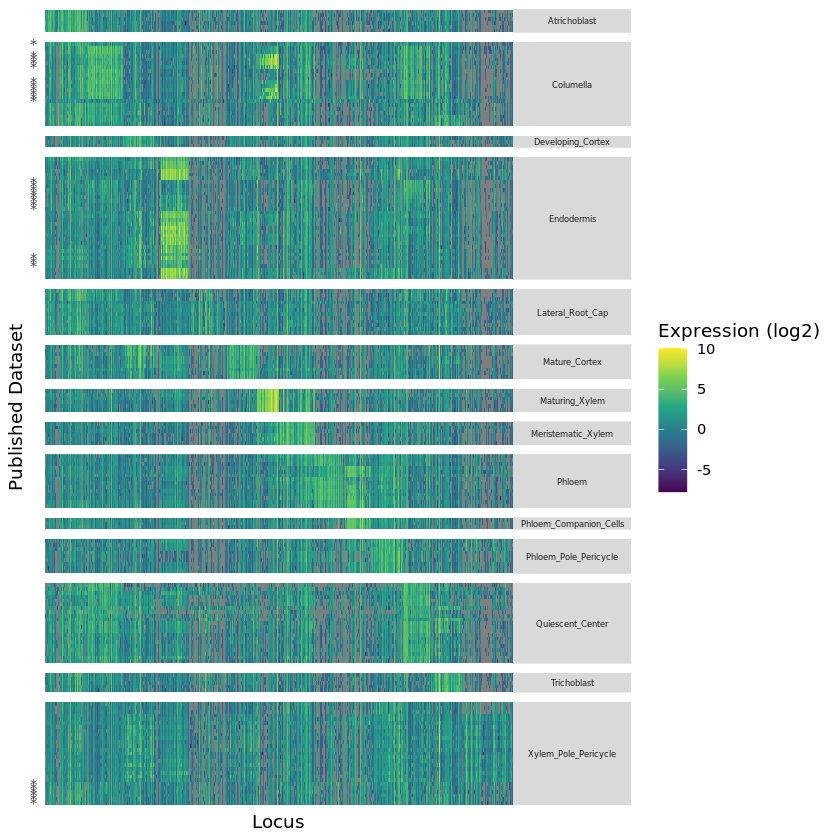

In [12]:
markers <- spec_table_markers %>% filter(is_marker) %>% arrange(Cell_Type, desc(spec)) %>% pull(Locus) %>% unique()
samples <- sorted_expression_data %>% arrange(Cell_Type) %>% pull(Sample_Name) %>% unique()

labels <- sorted_expression_data %>% dplyr::arrange(Cell_Type) %>% 
    dplyr::left_join(sample_metadata %>% mutate(Sample_Name = Filename)) %>% 
    dplyr::mutate(label = if_else(Exclude_1 == 1, "*", "")) %>% 
    dplyr::select(Sample_Name, label) %>% 
    tibble::deframe()

ggplot(mapping = aes(x = Locus, y = Sample_Name),
       data = sorted_expression_data %>% 
           mutate(Locus = factor(Locus, levels = markers),
                  Sample_Name = factor(Sample_Name, levels = samples))) + 
    geom_tile(aes(fill = log(Expression))) +
    scale_y_discrete(labels = labels) + 
    scale_fill_viridis_c(name = "Expression (log2)") + 
    labs(x = "Locus", y = "Published Dataset") +
    facet_grid(Cell_Type ~ 1, scales = 'free', space = 'free') +
    theme(strip.text.y.right = element_text(angle = 0, size = 5), 
          strip.text.x.top = element_blank(), 
          axis.text.x = element_blank(),
          axis.ticks.y = element_blank(),
          axis.ticks.x = element_blank())

## 4. Filter dataset 

In [14]:
# Filter expression data, excluding datasets that do not correlate well with others in the same cell type category
sorted_expression_data_filtered = sample_metadata %>%
    dplyr::filter(Filename %in% unique(c(dir("supp_data/published_datasets"), rnaseq_files, geo_files, arex_files))) %>%
    dplyr::filter(Exclude_1 == 0) %>%
    build_expression_table(probe_data = probe_data, exclude_loci = protoplast_loci, rnaseq_norm_method = "edgeR")

sorted_expression_data_filtered_rnaseq_only = sample_metadata %>%
    dplyr::filter(Filename %in% unique(c(dir("supp_data/published_datasets"), rnaseq_files, geo_files, arex_files))) %>%
    dplyr::filter(Exclude_1 == 0) %>%
    dplyr::filter(Type == "RNASeq") %>%
    build_expression_table(probe_data = probe_data, exclude_loci = protoplast_loci, rnaseq_norm_method = "edgeR")

Warning message in affy::read.affybatch(filenames):
“Incompatible phenoData object. Created a new one.
”


Adjusting for optical effect......................................................................................................Done.
Computing base-position profiles for probe affinitiesDone.
Computing affinities......................................................................................................Done.
Adjusting for non-specific binding......................................................................................................Done.
Normalizing
Calculating Expression


Joining, by = "array_element_name"

Parsed with column specification:
cols(
  .default = col_double(),
  Locus = col_character()
)

See spec(...) for full column specifications.

Joining, by = "Filename"



Design matrix not provided. Switch to the classic mode.


Joining, by = "Filename"

Parsed with column specification:
cols(
  .default = col_double(),
  Locus = col_character()
)

See spec(...) for full column specifications.

Joining, by = "Filename"



Design matrix not provided. Switch to the classic mode.


Joining, by = "Filename"



## 5. Re-compute specification tables

In [15]:
spec_table_filtered <- ICITools::compute_spec_table(expression_data = sorted_expression_data_filtered %>% 
                                                      dplyr::select(Sample_Name,
                                                             Expression,
                                                             Locus,
                                                             Cell_Type), 
                                                    bin_method = "Efroni", mean_method = "Efroni")


In [16]:
spec_table_filtered_rnaseq_only <- ICITools::compute_spec_table(expression_data = sorted_expression_data_filtered_rnaseq_only  %>% 
                                                                  dplyr::select(Sample_Name,
                                                                                Expression,
                                                                                Locus,
                                                                                Cell_Type), 
                                                                bin_method = "Efroni", mean_method = "Efroni")

## 6. Compute ICI scores

In [17]:
# Use both spec score tables to compute ICI scores for 100 cells of atlas
ici_rnaseq_ath1 <- ICITools::compute_ici_scores(expression_data = atlas_expression_data,
                                        spec_table = spec_table_filtered,
                                        min_spec_score = 0.15,
                                        information_level = 50, sig = TRUE)

ici_rnaseq_only <- ICITools::compute_ici_scores(expression_data = atlas_expression_data,
                                                    spec_table = spec_table_filtered_rnaseq_only,
                                                    min_spec_score = 0.15,
                                                    information_level = 50, sig = TRUE)

ici <- bind_rows(ici_rnaseq_ath1 %>% mutate(analysis = "ATH1RNASeq"),
                 ici_rnaseq_only %>% mutate(analysis = "RNASeq"))
head(ici)


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand




Cell_Type,ici_score,p_val,ici_score_norm,Cell,p_adj,analysis
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
Phloem_Pole_Pericycle,0.0009664723,1.000,0.004991592,AAACCCAAGCCATTCA_1,1,ATH1RNASeq
Endodermis,0.0009063322,1.000,0.004680984,AAACCCAAGCCATTCA_1,1,ATH1RNASeq
Phloem_Companion_Cells,0.0043682071,0.999,0.022560720,AAACCCAAGCCATTCA_1,1,ATH1RNASeq
Mature_Cortex,0.0440145065,0.222,0.227324144,AAACCCAAGCCATTCA_1,1,ATH1RNASeq
Phloem,0.0000000000,1.000,0.000000000,AAACCCAAGCCATTCA_1,1,ATH1RNASeq
Maturing_Xylem,0.0312149307,0.721,0.161217471,AAACCCAAGCCATTCA_1,1,ATH1RNASeq


## 7. Save ICI output 

In [19]:
readr::write_csv(ici, path = "ici_raw.csv.bz2")

## 8. Plot ICI scores on UMAP

Joining, by = "Cell"



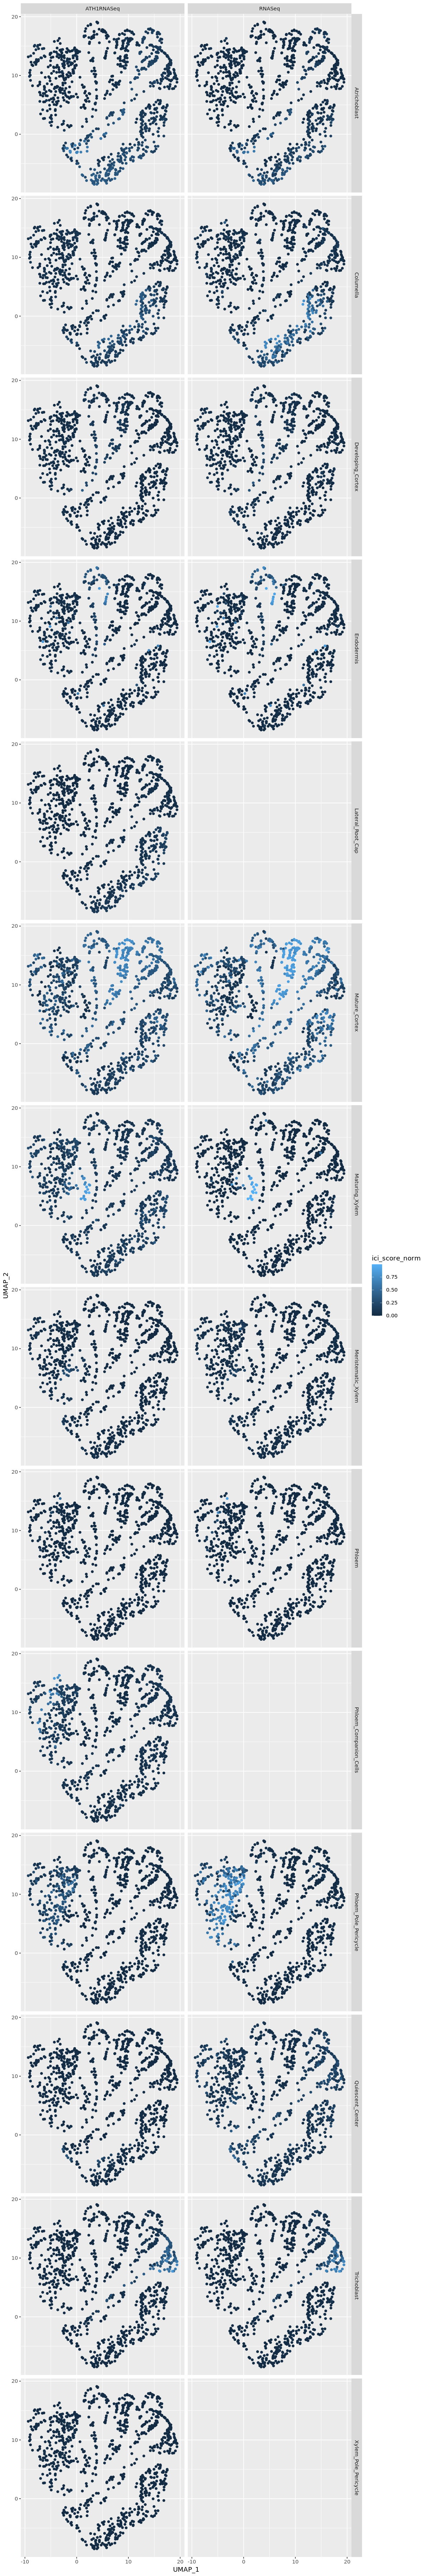

In [24]:
options(repr.plot.width=10, repr.plot.height=60)
umap <- readr::read_rds("Root_Atlas.rds")@reductions$umap@cell.embeddings %>% as_tibble(rownames = "Cell")
ggplot(left_join(ici, umap), aes(x = UMAP_1, y = UMAP_2)) + geom_point(aes(color = ici_score_norm)) + facet_grid(Cell_Type ~ analysis)